# Web Scraping & Predicting

In this project, we will practice two major skills. Collecting data by scraping a website and building a binary predictor with Logistic Regression.

In [497]:
print "Blog Post: http://mattbrownblog.tumblr.com/post/152602828599/learning-to-code-part-3-categorical"

Blog Post: http://mattbrownblog.tumblr.com/post/152602828599/learning-to-code-part-3-categorical


### Step 1: Scrape your site

We will be scraping your website using BeautifulSoup. Write your code below.

In [498]:
# Import Packages
import numpy as np
import pandas as pd
import patsy
import time 
import requests
import ast
import string
import dateutil.parser


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV

import urllib2
from bs4 import BeautifulSoup
import json

### Write functions to extract the features you think correlate well with your dataset. You MUST have at least 4 features!

- **Make sure these functions are robust and can handle cases where fields may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

In [500]:
# Load APIs

headers = {'Ocp-Apim-Subscription-Key': 'a09fab6dcce04187a3a382da086e4f7a'}

# MAPs API + DataFrame
url4 = 'https://www.haloapi.com/metadata/h5/metadata/maps'
response4 = requests.get(url4, params=None, headers=headers)
Maps_JSON = json.loads(response4.text)

maps_df = pd.DataFrame(Maps_JSON)
maps_df_2 = maps_df.loc[:, ['id', 'name']]
maps_df_2.columns = ['id','Map_Name']

# Match Stats API
url2 = 'https://www.haloapi.com/stats/h5/arena/matches/37fe79e7-befe-4c9b-acee-c05eb6562f8b'
response2 = requests.get(url2, params=None, headers=headers)
match_stats_JSON = json.loads(response2.text)

# Leaderboards API
url3 = 'https://www.haloapi.com/stats/h5/player-leaderboards/csr/8c7d848f-1437-4ce1-8e6a-f41850075d01/892189e9-d712-4bdb-afa7-1ccab43fbed4?count=50'
response3 = requests.get(url3, params=None, headers=headers)

Leaderboards_JSON = json.loads(response3.text)

In [539]:
match_history_JSON

{u'Count': 25,
 u'Links': {u'Self': {u'AcknowledgementTypeId': 0,
   u'AuthenticationLifetimeExtensionSupported': False,
   u'AuthorityId': u'spartanstats',
   u'Path': u'/h5/players/madballa55/matches',
   u'QueryString': u'?include-xuids=false&view=full&include-ratings=false&include-times=false&modes=arena&start=0',
   u'RetryPolicyId': u'',
   u'TopicName': u''}},
 u'ResultCount': 25,
 u'Results': [{u'GameBaseVariantId': u'257a305e-4dd3-41f1-9824-dfe7e8bd59e1',
   u'GameVariant': {u'Owner': u'',
    u'OwnerType': 3,
    u'ResourceId': u'dc87b3e6-cbb7-4c08-b9a3-951429561177',
    u'ResourceType': 2},
   u'HopperId': u'892189e9-d712-4bdb-afa7-1ccab43fbed4',
   u'Id': {u'GameMode': 1,
    u'MatchId': u'c6410af3-3f5b-4b5c-8955-695800db8730'},
   u'IsTeamGame': True,
   u'Links': {u'StatsMatchDetails': {u'AcknowledgementTypeId': 0,
     u'AuthenticationLifetimeExtensionSupported': False,
     u'AuthorityId': u'spartanstats',
     u'Path': u'h5/arena/matches/c6410af3-3f5b-4b5c-8955-695800

In [540]:
# Create Function that calls API and builds dataframe

def load_data(start):
    
    url = 'https://www.haloapi.com/stats/h5/players/madballa55/matches?modes=arena&start={}'.format(start)
    headers = {'Ocp-Apim-Subscription-Key': 'a09fab6dcce04187a3a382da086e4f7a'}
    response = requests.get(url, params=None, headers=headers)

    match_history_JSON = json.loads(response.text)

    # Create Empty Dictionary for DataFrame
    dicty_df = []


    # Fill in columns with JSON data
    for a in match_history_JSON['Results']:
        dicty_df+=[{
         'Match_ID' : a['Id']['MatchId'], 
         'Kills': a['Players'][0]['TotalKills'],
         'Deaths': a['Players'][0]['TotalDeaths'],
         'Assists': a['Players'][0]['TotalAssists'],
         'Individual_Rank': a['Players'][0]['Rank'],
         'Win_Loss': a['Players'][0]['Result'],
         'Team_ID': a['Players'][0]['TeamId'],
         'Map_ID': a['MapId'],
         'Match_Duration': a['MatchDuration'],
         'Match_Date': dateutil.parser.parse(a['MatchCompletedDate']['ISO8601Date']),
         'Gamertag': a['Players'][0]['Player']['Gamertag'],
         'Score_1': a['Teams'][0]['Score'],
         'Score_2': a['Teams'][1]['Score'],          
        }]


    # Create dictionary
    df = pd.DataFrame(dicty_df)

    # Merging Map Name into df
    df = pd.merge(maps_df_2, df, how='inner', left_on='id', right_on='Map_ID')

    return df

In [541]:
# Create Master DataFrame that API's will append onto
master_df = load_data(0)

# Create loop that appends more data onto master_df
for x in range(26,1500,26):
    master_df = master_df.append(load_data_2(x))
    time.sleep(5)

In [542]:
# Make sure there is 1K+ rows
print len(master_df)

master_df.head()

1450


,id,Map_Name,Assists,Deaths,Gamertag,Individual_Rank,Kills,Map_ID,Match_Date,Match_Duration,Match_ID,Score_1,Score_2,Team_ID,Win_Loss
0,cd844200-f206-11e4-9393-24be05e24f7e,Eden,9,7,madballa55,4,7,cd844200-f206-11e4-9393-24be05e24f7e,2016-10-27 00:00:00+00:00,PT8M53.1322373S,37fe79e7-befe-4c9b-acee-c05eb6562f8b,38,50,1,3
1,cd844200-f206-11e4-9393-24be05e24f7e,Eden,7,9,madballa55,3,15,cd844200-f206-11e4-9393-24be05e24f7e,2016-10-23 00:00:00+00:00,PT9M32.0536273S,1d18f01d-e95c-41d5-be96-602ade5082b2,50,35,0,3
2,cdb934b0-f206-11e4-8810-24be05e24f7e,Empire,0,3,madballa55,7,0,cdb934b0-f206-11e4-8810-24be05e24f7e,2016-10-22 00:00:00+00:00,PT9M28.2209101S,0e39ef33-efcc-45b1-811f-9ee4cdde8011,33,50,0,0
3,cc040aa1-f206-11e4-a3e0-24be05e24f7e,Fathom,6,13,madballa55,3,12,cc040aa1-f206-11e4-a3e0-24be05e24f7e,2016-11-01 00:00:00+00:00,PT10M1.089307S,c6410af3-3f5b-4b5c-8955-695800db8730,49,50,0,3
4,cc040aa1-f206-11e4-a3e0-24be05e24f7e,Fathom,7,12,madballa55,1,17,cc040aa1-f206-11e4-a3e0-24be05e24f7e,2016-10-23 00:00:00+00:00,PT9M6.4294104S,af4b244f-010a-4293-8a86-f65a1499ffe8,50,45,0,3


### Make sure you have at least 1000 rows before continuing.

#### Clean up / standardize your data here

- Dates converted to correct format
- Remove dollar signs, spaces, periods
- etc

In [543]:
# Turn columns into int, float, dates.
master_df.Kills = master_df.Kills.astype(int)
master_df.Deaths = master_df.Deaths.astype(int)
master_df.Assists = master_df.Assists.astype(int)
master_df.Individual_Rank = master_df.Individual_Rank.astype(int)
master_df.Win_Loss = master_df.Win_Loss.astype(int)
master_df.Score_1 = master_df.Score_1.astype(int)
master_df.Score_2 = master_df.Score_2.astype(int)


master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 24
Data columns (total 15 columns):
id                 1450 non-null object
Map_Name           1450 non-null object
Assists            1450 non-null int64
Deaths             1450 non-null int64
Gamertag           1450 non-null object
Individual_Rank    1450 non-null int64
Kills              1450 non-null int64
Map_ID             1450 non-null object
Match_Date         1450 non-null datetime64[ns, UTC]
Match_Duration     1450 non-null object
Match_ID           1450 non-null object
Score_1            1450 non-null int64
Score_2            1450 non-null int64
Team_ID            1450 non-null int64
Win_Loss           1450 non-null int64
dtypes: datetime64[ns, UTC](1), int64(8), object(6)
memory usage: 181.2+ KB


### Create a dataframe to compile the results of your data cleaning.

In [544]:
## YOUR CODE HERE

master_df.head()

,id,Map_Name,Assists,Deaths,Gamertag,Individual_Rank,Kills,Map_ID,Match_Date,Match_Duration,Match_ID,Score_1,Score_2,Team_ID,Win_Loss
0,cd844200-f206-11e4-9393-24be05e24f7e,Eden,9,7,madballa55,4,7,cd844200-f206-11e4-9393-24be05e24f7e,2016-10-27 00:00:00+00:00,PT8M53.1322373S,37fe79e7-befe-4c9b-acee-c05eb6562f8b,38,50,1,3
1,cd844200-f206-11e4-9393-24be05e24f7e,Eden,7,9,madballa55,3,15,cd844200-f206-11e4-9393-24be05e24f7e,2016-10-23 00:00:00+00:00,PT9M32.0536273S,1d18f01d-e95c-41d5-be96-602ade5082b2,50,35,0,3
2,cdb934b0-f206-11e4-8810-24be05e24f7e,Empire,0,3,madballa55,7,0,cdb934b0-f206-11e4-8810-24be05e24f7e,2016-10-22 00:00:00+00:00,PT9M28.2209101S,0e39ef33-efcc-45b1-811f-9ee4cdde8011,33,50,0,0
3,cc040aa1-f206-11e4-a3e0-24be05e24f7e,Fathom,6,13,madballa55,3,12,cc040aa1-f206-11e4-a3e0-24be05e24f7e,2016-11-01 00:00:00+00:00,PT10M1.089307S,c6410af3-3f5b-4b5c-8955-695800db8730,49,50,0,3
4,cc040aa1-f206-11e4-a3e0-24be05e24f7e,Fathom,7,12,madballa55,1,17,cc040aa1-f206-11e4-a3e0-24be05e24f7e,2016-10-23 00:00:00+00:00,PT9M6.4294104S,af4b244f-010a-4293-8a86-f65a1499ffe8,50,45,0,3


### Fill all the empty values with the column means or remove the rows from your table depending on your circumstances

In [281]:
## YOUR CODE HERE

print('No empty column values exist')

No empty column values exist


### Save your results as a CSV

In [549]:
## YOUR CODE HERE

# Creating binary win/lose columns before exporting.
master_df.loc[df['Win_Loss'] > 1 , 'Win_Loss_Binary'] = 1
master_df.loc[df['Win_Loss'] < 3 , 'Win_Loss_Binary'] = 0

#master_df.insert(4,'KD_Spread', master_df.Kills - master_df.Deaths, allow_duplicates=False)
master_df.to_csv('./../assets/Halo_Data.csv', sep=',', encoding='utf-8')

master_df_2 = master_df

master_df_2['Match_Date'] = pd.to_datetime(master_df_2['Match_Date'], format='%Y%M%D')

master_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 24
Data columns (total 16 columns):
id                 1450 non-null object
Map_Name           1450 non-null object
Assists            1450 non-null int64
Deaths             1450 non-null int64
Gamertag           1450 non-null object
Individual_Rank    1450 non-null int64
Kills              1450 non-null int64
Map_ID             1450 non-null object
Match_Date         1450 non-null datetime64[ns, UTC]
Match_Duration     1450 non-null object
Match_ID           1450 non-null object
Score_1            1450 non-null int64
Score_2            1450 non-null int64
Team_ID            1450 non-null int64
Win_Loss           1450 non-null int64
Win_Loss_Binary    1450 non-null float64
dtypes: datetime64[ns, UTC](1), float64(1), int64(8), object(6)
memory usage: 192.6+ KB


## Predicting win/loss using Logistic Regression

### We want to predict whether the target was in a range or not with a binary variable. Create binary variables for some of your non-binary features, so we can draw correlations. See the logisitic regression lab if you are having trouble understanding the instructions. 

In [492]:
# Create Column For KD_Spread
master_df.insert(4,'KD_Spread', master_df.Kills - master_df.Deaths, allow_duplicates=False)

# More than average variables
master_df.loc[master_df['Assists'] > np.mean(master_df.Assists) , 'Assists_>_Mean'] = 1
master_df.loc[master_df['Deaths'] < np.mean(master_df.Deaths) , 'Deaths_<_Mean'] = 1
master_df.loc[master_df['Kills'] > np.mean(master_df.Kills) , 'Kills_>_Mean'] = 1
master_df.loc[master_df['KD_Spread'] > np.mean(master_df.KD_Spread) , 'KD_Spread_>_Mean'] = 1

master_df.fillna(0, inplace = True)

master_df.head()

print len(master_df)

1175


### Thought experiment: What is the baseline accuracy for this model?

In [398]:
## YOUR CODE HERE

print "It's a 50% chance becuase its just 2 teams vs eachother and only 1 can win."


It's a 50% chance becuase its just 2 teams vs eachother and only 1 can win.


### Create a Logistic Regression model to predict your target using statsmodel. Start by ONLY using one feature. Display the coefficients and write a short summary of what each feature means.

In [489]:
## YOUR CODE HERE

import statsmodels.formula.api as sm

model = sm.logit("Win_Loss_Binary ~ KD_Spread",data = master_df).fit()

print "This is telling me that 1 point in KD Spread, it increases my likelhood of winning by 24%."

model.summary()


Optimization terminated successfully.
         Current function value: 0.685356
         Iterations 4
This is telling me that 1 point in KD Spread, it increases my likelhood of winning by 24%.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Win_Loss_Binary   No. Observations:                 1175
Model:                          Logit   Df Residuals:                     1173
Method:                           MLE   Df Model:                            1
Date:                Tue, 01 Nov 2016   Pseudo R-squ.:               0.0008372
Time:                        08:19:40   Log-Likelihood:                -805.29
converged:                       True   LL-Null:                       -805.97
                                        LLR p-value:                    0.2454
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2526      0.060      4.234      0.000         0.136     0.370
KD_Spread     -0.0137      0.012     -1.161      0.246        -0.037     0.009
==============================================================================
"""

#### Create a few new variables in your dataframe to represent interesting aspects of your features.
- For example, create a feature that represents whether 'Senior' is in the title when dealing with employment statistics
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [490]:
# Creating 2 new columns for KD Spread and KD Ratio.
master_df.insert(5, 'KD_Ratio', master_df.Kills / master_df.Deaths, allow_duplicates=False)
master_df.insert(6, 'KDA_Ratio', (master_df.Kills + master_df.Assists) / master_df.Deaths)

In [491]:
master_df.KD_Spread = master_df.KD_Spread.astype(float)
master_df.KD_Ratio = master_df.KD_Ratio.astype(float)
master_df.KDA_Ratio = master_df.KDA_Ratio.astype(float)

df.head()


,id,Map_Name,Match_ID,Kills,Deaths,KD_Ratio,KDA_Ratio,Assists,Team_ID,Map_ID,Match_Duration,Match_Date,Individual_Rank,Win_Loss,Gamertag
0,cd844200-f206-11e4-9393-24be05e24f7e,Eden,37fe79e7-befe-4c9b-acee-c05eb6562f8b,7,7,1,2.28571,9,1,cd844200-f206-11e4-9393-24be05e24f7e,PT8M53.1322373S,2016-10-27T00:00:00Z,4,3,madballa55
1,cd844200-f206-11e4-9393-24be05e24f7e,Eden,1d18f01d-e95c-41d5-be96-602ade5082b2,15,9,1.66667,2.44444,7,0,cd844200-f206-11e4-9393-24be05e24f7e,PT9M32.0536273S,2016-10-23T00:00:00Z,3,3,madballa55
2,cdb934b0-f206-11e4-8810-24be05e24f7e,Empire,0e39ef33-efcc-45b1-811f-9ee4cdde8011,0,3,0,0,0,0,cdb934b0-f206-11e4-8810-24be05e24f7e,PT9M28.2209101S,2016-10-22T00:00:00Z,7,0,madballa55
3,cc040aa1-f206-11e4-a3e0-24be05e24f7e,Fathom,af4b244f-010a-4293-8a86-f65a1499ffe8,17,12,1.41667,2,7,0,cc040aa1-f206-11e4-a3e0-24be05e24f7e,PT9M6.4294104S,2016-10-23T00:00:00Z,1,3,madballa55
4,caacb800-f206-11e4-81ab-24be05e24f7e,Plaza,dbca361f-30f2-4868-a4b5-af92114495ff,9,11,0.818182,1.81818,11,0,caacb800-f206-11e4-81ab-24be05e24f7e,PT9M22.1161921S,2016-10-22T00:00:00Z,8,1,madballa55


#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [416]:
# Create dummy variables for MAP Name

master_df = pd.concat([master_df, pd.get_dummies(master_df['Map_Name'])], axis=1)

master_df.head()

print list(master_df.columns.values)

['id', 'Map_Name', 'Match_ID', 'Kills', 'KD_Spread', 'KD_Ratio', 'KDA_Ratio', 'Deaths', 'Assists', 'Team_ID', 'Map_ID', 'Match_Duration', 'Match_Date', 'Individual_Rank', 'Win_Loss', 'Gamertag', 'Win_Loss_Binary', 'Assists_>_Mean', 'Deaths_<_Mean', 'Kills_>_Mean', 'KD_Spread_>_Mean', u'Alpine', u'Coliseum', u'Eden', u'Empire', u'Fathom', u'Glacier', u'Mercy', u'Overgrowth', u'Parallax', u'Plaza', u'Regret', u'Riptide\xa0', u'Slag', u'Stasis', u'The Rig', u'Torque', u'Truth', u'Tyrant', u'Alpine', u'Coliseum', u'Eden', u'Empire', u'Fathom', u'Glacier', u'Mercy', u'Overgrowth', u'Parallax', u'Plaza', u'Regret', u'Riptide\xa0', u'Slag', u'Stasis', u'The Rig', u'Torque', u'Truth', u'Tyrant']


In [447]:
# Assign input and output data
from sklearn.linear_model import LogisticRegression

X = master_df[['Assists_>_Mean','Kills_>_Mean','Deaths_<_Mean','KD_Spread_>_Mean']]
#X = master_df[['Assists','Kills','Deaths','KD_Spread']]

y = master_df['Win_Loss_Binary']


In [462]:
# Set model to Logistic Regression and Get best C Value + Regularization Model
model = LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(model, {'penalty':penalties, 'C':C_vals}, verbose=True, cv=5, scoring='f1_macro')
gs.fit(X, y)

gs.best_params_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.8s finished


{'C': 0.1, 'penalty': 'l1'}

In [466]:
from sklearn.linear_model import LogisticRegression

# Train, Test, Split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.80, random_state=77)

# Create the Model
model = LogisticRegression(C=.1, penalty='l2', solver='liblinear')
model.fit(X, y)



# Predict Outputs
predictions = model.predict(X)

print model.coef_

print 'Finding: It is more important to have above average assists than kills or KD spread '

[[ 1.76326436  1.20216868  0.23738218 -0.52517074]]
Finding: It is more important to have above average assists than kills or KD spread 


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [468]:
# Cross_Val_Score
from sklearn.model_selection import cross_val_score
print 'Cross_Val_Score: ', cross_val_score(model, X, y)
print '\n'

print classification_report(y, predictions)
print pd.DataFrame(confusion_matrix(y, predictions), index = ['Loss', 'Win'], columns = ['Loss', 'Win'])


Cross_Val_Score:  [ 0.72933884  0.70867769  0.72614108]


             precision    recall  f1-score   support

        0.0       0.73      0.62      0.67       638
        1.0       0.73      0.82      0.78       812

avg / total       0.73      0.73      0.73      1450

      Loss  Win
Loss   396  242
Win    144  668


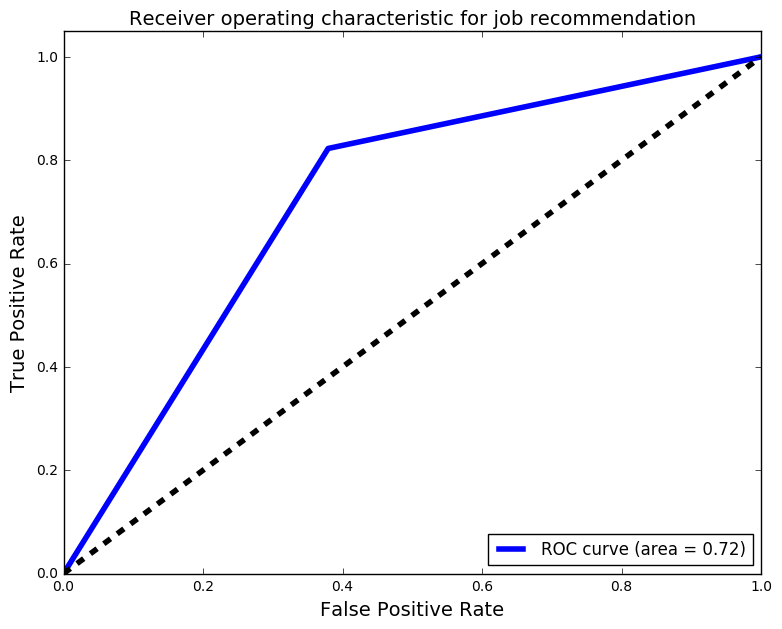

In [469]:
# ROC Curve
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt


FPR, TPR, thresholds = roc_curve(y, predictions)

ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[9,7])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic for job recommendation', fontsize=14)
plt.legend(loc="lower right")
plt.show()

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [470]:
## YOUR CODE HERE
# L1

from sklearn.linear_model import LogisticRegression

# Create the Model
model = LogisticRegression(C=.0001, penalty='l1', solver='liblinear')
model.fit(X, y)

# Predict Outputs
predictions = model.predict(X)

model.coef_



array([[ 0.,  0.,  0.,  0.]])

In [471]:
# Cross_Val_Score
from sklearn.model_selection import cross_val_score
print 'Cross_Val_Score: ', cross_val_score(model, X, y)
print '\n'

print(classification_report(y, predictions))
print pd.DataFrame(confusion_matrix(y, predictions), index = ['Loss', 'Win'], columns = ['Loss', 'Win'])

Cross_Val_Score:  [ 0.44008264  0.44008264  0.43983402]


             precision    recall  f1-score   support

        0.0       0.44      1.00      0.61       638
        1.0       0.00      0.00      0.00       812

avg / total       0.19      0.44      0.27      1450

      Loss  Win
Loss   638    0
Win    812    0


### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from text summaries if they exist. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [23]:
## YOUR CODE HERE

In [24]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [25]:
## YOUR CODE HERE